# Hydrological Modeling

We treat the climate system as a collection of reservoirs where mass is conserved. 

## Defining the Model Structure:
1. **Stocks (Reservoirs):** The state variables representing the amount of water mass in a specific location.
2. **Flows:** The movement of mass between stocks.
3. **Rules:** The mathematical equations that determine the rate of flows.
4. **Parameters:** The physical constants that tune the efficiency of those rules.

In this version, we model three primary stocks:
- **Atmospheric Water ($W_a$)**
- **Surface Water ($W_s$)**
- **Ground Water ($W_g$)**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Initial Stock Values (Mass)
INIT_W_ATM = 50.0
INIT_W_SUR = 200.0
INIT_W_GRN = 1200.0

# Simulation settings
TOTAL_DAYS = 1000
DT = 0.1

# Linear Model Constants
K_PRECIP_LIN = 0.1
K_EVAP_LIN   = 0.01
K_INFILT_LIN = 0.05
K_BASE_LIN   = 0.005

# Advanced Model Constants
K_PRECIP_NONLIN   = 0.003
POTENTIAL_EVAP    = 10.0
SATURATION_LIMIT  = 100.0
GROUND_CAPACITY   = 2000.0
INFILT_EFFICIENCY = 0.05
CONSTANT_SPRING   = 5.0

## Conservation Laws:
Mathematically, for any stock $i$, the change over time is:
$$\frac{dW_i}{dt} = \sum \text{Inflows} - \sum \text{Outflows}$$

In [2]:
def run_hydrology_engine(days, dt, w_a, w_s, w_g, precip_rule, evap_rule, infilt_rule, 
                         baseflow_rule):
    
    t = np.arange(0, days, dt)
    W_atm, W_sur, W_grn = [np.zeros(len(t)) for _ in range(3)]

    # The values are initialized at the first time step
    W_atm[0], W_sur[0], W_grn[0] = w_a, w_s, w_g

    for i in range(len(t) - 1):
        # Calculate flows using provided Rules
        p = precip_rule(W_atm[i], W_sur[i], W_grn[i])
        e = evap_rule(W_atm[i], W_sur[i], W_grn[i])
        inf = infilt_rule(W_atm[i], W_sur[i], W_grn[i])
        b = baseflow_rule(W_atm[i], W_sur[i], W_grn[i])
        
        # Apply Conservation - Euler Integration
        W_atm[i+1] = W_atm[i] + (e - p) * dt
        W_sur[i+1] = W_sur[i] + (p + b - e - inf) * dt
        W_grn[i+1] = W_grn[i] + (inf - b) * dt
        
    return t, W_atm, W_sur, W_grn

## Defining the Rules:

### Why Nonlinear Rules?
In a real climate system, physical processes are rarely linear. The **Advanced Rules** represent a significant improvement over the **Linear Rules** by incorporating feedbacks and physical limits:

- **Nonlinear Precipitation ($k \cdot W_a^2$):** In nature, as the atmosphere becomes more loaded with water vapor, the probability of droplet collision and cloud formation increases nonlinearly. This creates a stronger 'self-correcting' mechanism than a linear rule.
- **Saturation-Limited Evaporation:** Evaporation depends on the air's capacity to hold more moisture. If the atmosphere is near its `SATURATION_LIMIT`, evaporation must slow down, regardless of how much surface water is available. This couples the $W_s$ and $W_a$ stocks in a way that linear models cannot.
- **Capacity-Limited Infiltration:** The ground acts like a sponge. As it fills toward `GROUND_CAPACITY`, it becomes harder for surface water to penetrate the soil. This introduces a **negative feedback** that stabilizes the groundwater stock.

In [3]:
# Standard Linear Rules
def linear_precip(wa, ws, wg): return K_PRECIP_LIN * wa
def linear_evap(wa, ws, wg):   return K_EVAP_LIN * ws
def linear_infilt(wa, ws, wg): return K_INFILT_LIN * ws
def linear_base(wa, ws, wg):   return K_BASE_LIN * wg

# Non Linear Rules
def nonlinear_precip(wa, ws, wg): 
    return K_PRECIP_NONLIN * (wa**2)

def saturation_evap(wa, ws, wg): 
    return POTENTIAL_EVAP * max(0, (1 - wa / SATURATION_LIMIT))

def soil_limited_infilt(wa, ws, wg): 
    return INFILT_EFFICIENCY * ws * (1 - wg / GROUND_CAPACITY)

def constant_base(wa, ws, wg): 
    return CONSTANT_SPRING

## Model Evaluation
By comparing a linear world to a nonlinear world, we can identify **Feedbacks**.

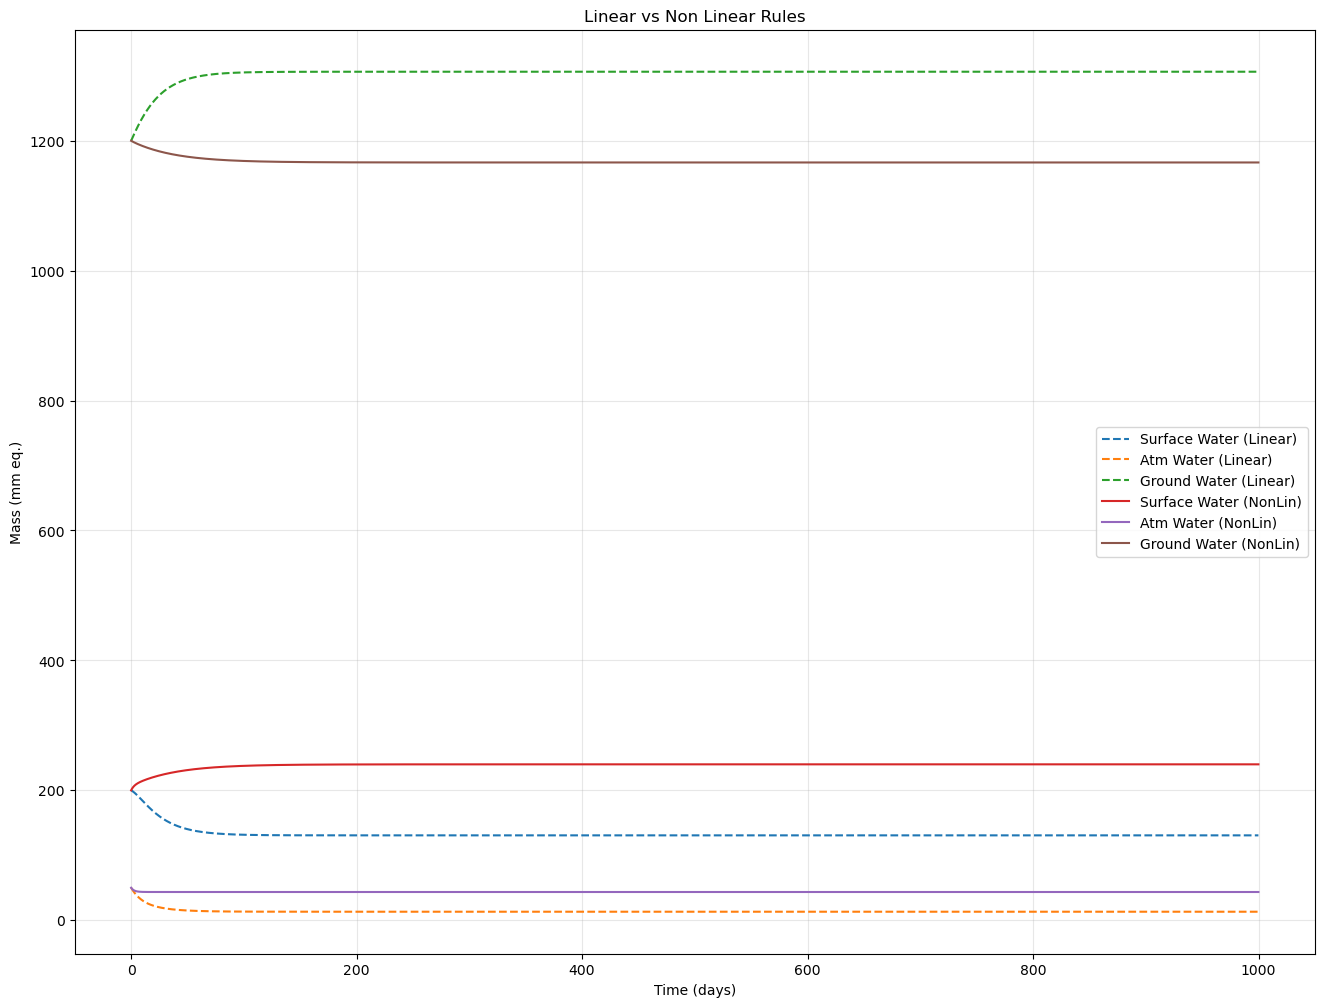

In [13]:
t, atm_a, sur_a, grn_a = run_hydrology_engine(
    TOTAL_DAYS, DT, INIT_W_ATM, INIT_W_SUR, INIT_W_GRN,
    linear_precip, linear_evap, linear_infilt, linear_base
)

_, atm_b, sur_b, grn_b = run_hydrology_engine(
    TOTAL_DAYS, DT, INIT_W_ATM, INIT_W_SUR, INIT_W_GRN,
    nonlinear_precip, saturation_evap, soil_limited_infilt, constant_base
)

plt.figure(figsize=(16, 12))
plt.plot(t, sur_a, label='Surface Water (Linear)', ls="--")
plt.plot(t, atm_a, label='Atm Water (Linear)', ls="--")
plt.plot(t, grn_a, label='Ground Water (Linear)', ls="--")
plt.plot(t, sur_b, label='Surface Water (NonLin)')
plt.plot(t, atm_b, label='Atm Water (NonLin)')
plt.plot(t, grn_b, label='Ground Water (NonLin)')
plt.title('Linear vs Non Linear Rules')
plt.ylabel('Mass (mm eq.)')
plt.xlabel('Time (days)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Sensitivity Analysis
If a small change in a parameter causes a massive change in the output, we must measure that parameter very carefully in the real world.

Instead of manually changing parameters and re-running the cell, we use a **loop**

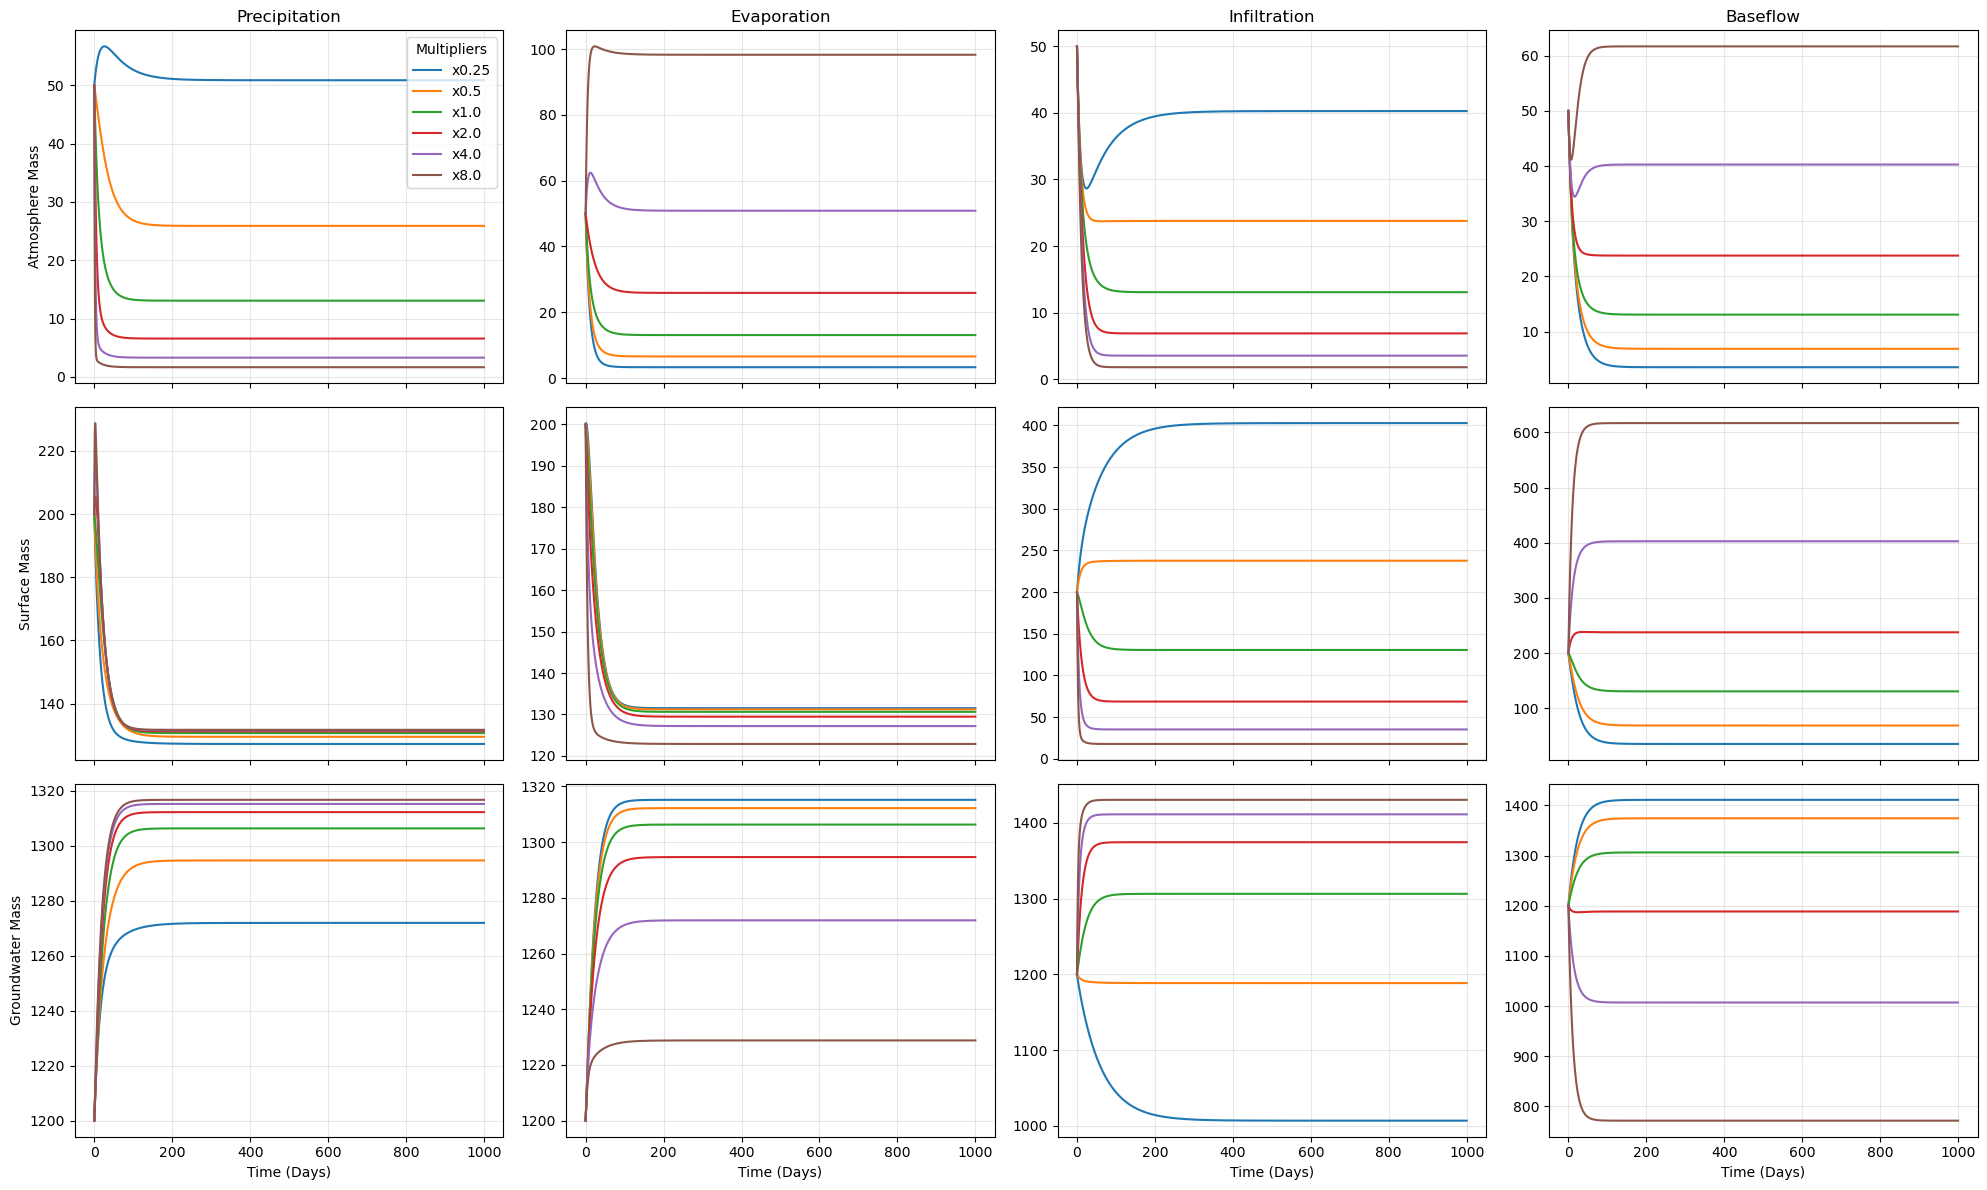

In [18]:
# This snippet changes K_PRECIP, K_EVAP, K_INFILT, K_BASE all for linear rules and makes finding the sensitive parameter easier!

parameter_names = ['Precipitation', 'Evaporation', 'Infiltration', 'Baseflow']
multipliers = [0.25, 0.5, 1.0, 2.0, 4.0, 8.0]

fig, axes = plt.subplots(3, 4, sharex=True, figsize=(20, 12))

for col, param_name in enumerate(parameter_names):
    for mult in multipliers:

        p_rule = linear_precip
        e_rule = linear_evap
        i_rule = linear_infilt
        b_rule = linear_base
        
        if param_name == 'Precipitation':
            p_rule = lambda wa, ws, wg, m=mult: m * linear_precip(wa, ws, wg)
        elif param_name == 'Evaporation':
            e_rule = lambda wa, ws, wg, m=mult: m * linear_evap(wa, ws, wg)
        elif param_name == 'Infiltration':
            i_rule = lambda wa, ws, wg, m=mult: m * linear_infilt(wa, ws, wg)
        elif param_name == 'Baseflow':
            b_rule = lambda wa, ws, wg, m=mult: m * linear_base(wa, ws, wg)
            
        t_s, atm_s, sur_s, grn_s = run_hydrology_engine(
            TOTAL_DAYS, DT, INIT_W_ATM, INIT_W_SUR, INIT_W_GRN,
            p_rule, e_rule, i_rule, b_rule
        )
        
        axes[0, col].plot(t_s, atm_s, label=f'x{mult}')
        axes[1, col].plot(t_s, sur_s)
        axes[2, col].plot(t_s, grn_s)
        
    axes[0, col].set_title(param_name)

axes[0, 0].set_ylabel('Atmosphere Mass')
axes[1, 0].set_ylabel('Surface Mass')
axes[2, 0].set_ylabel('Groundwater Mass')

for col in range(4):
    axes[2, col].set_xlabel('Time (Days)')

axes[0, 0].legend(title="Multipliers")

for ax in axes.flatten():
    ax.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()

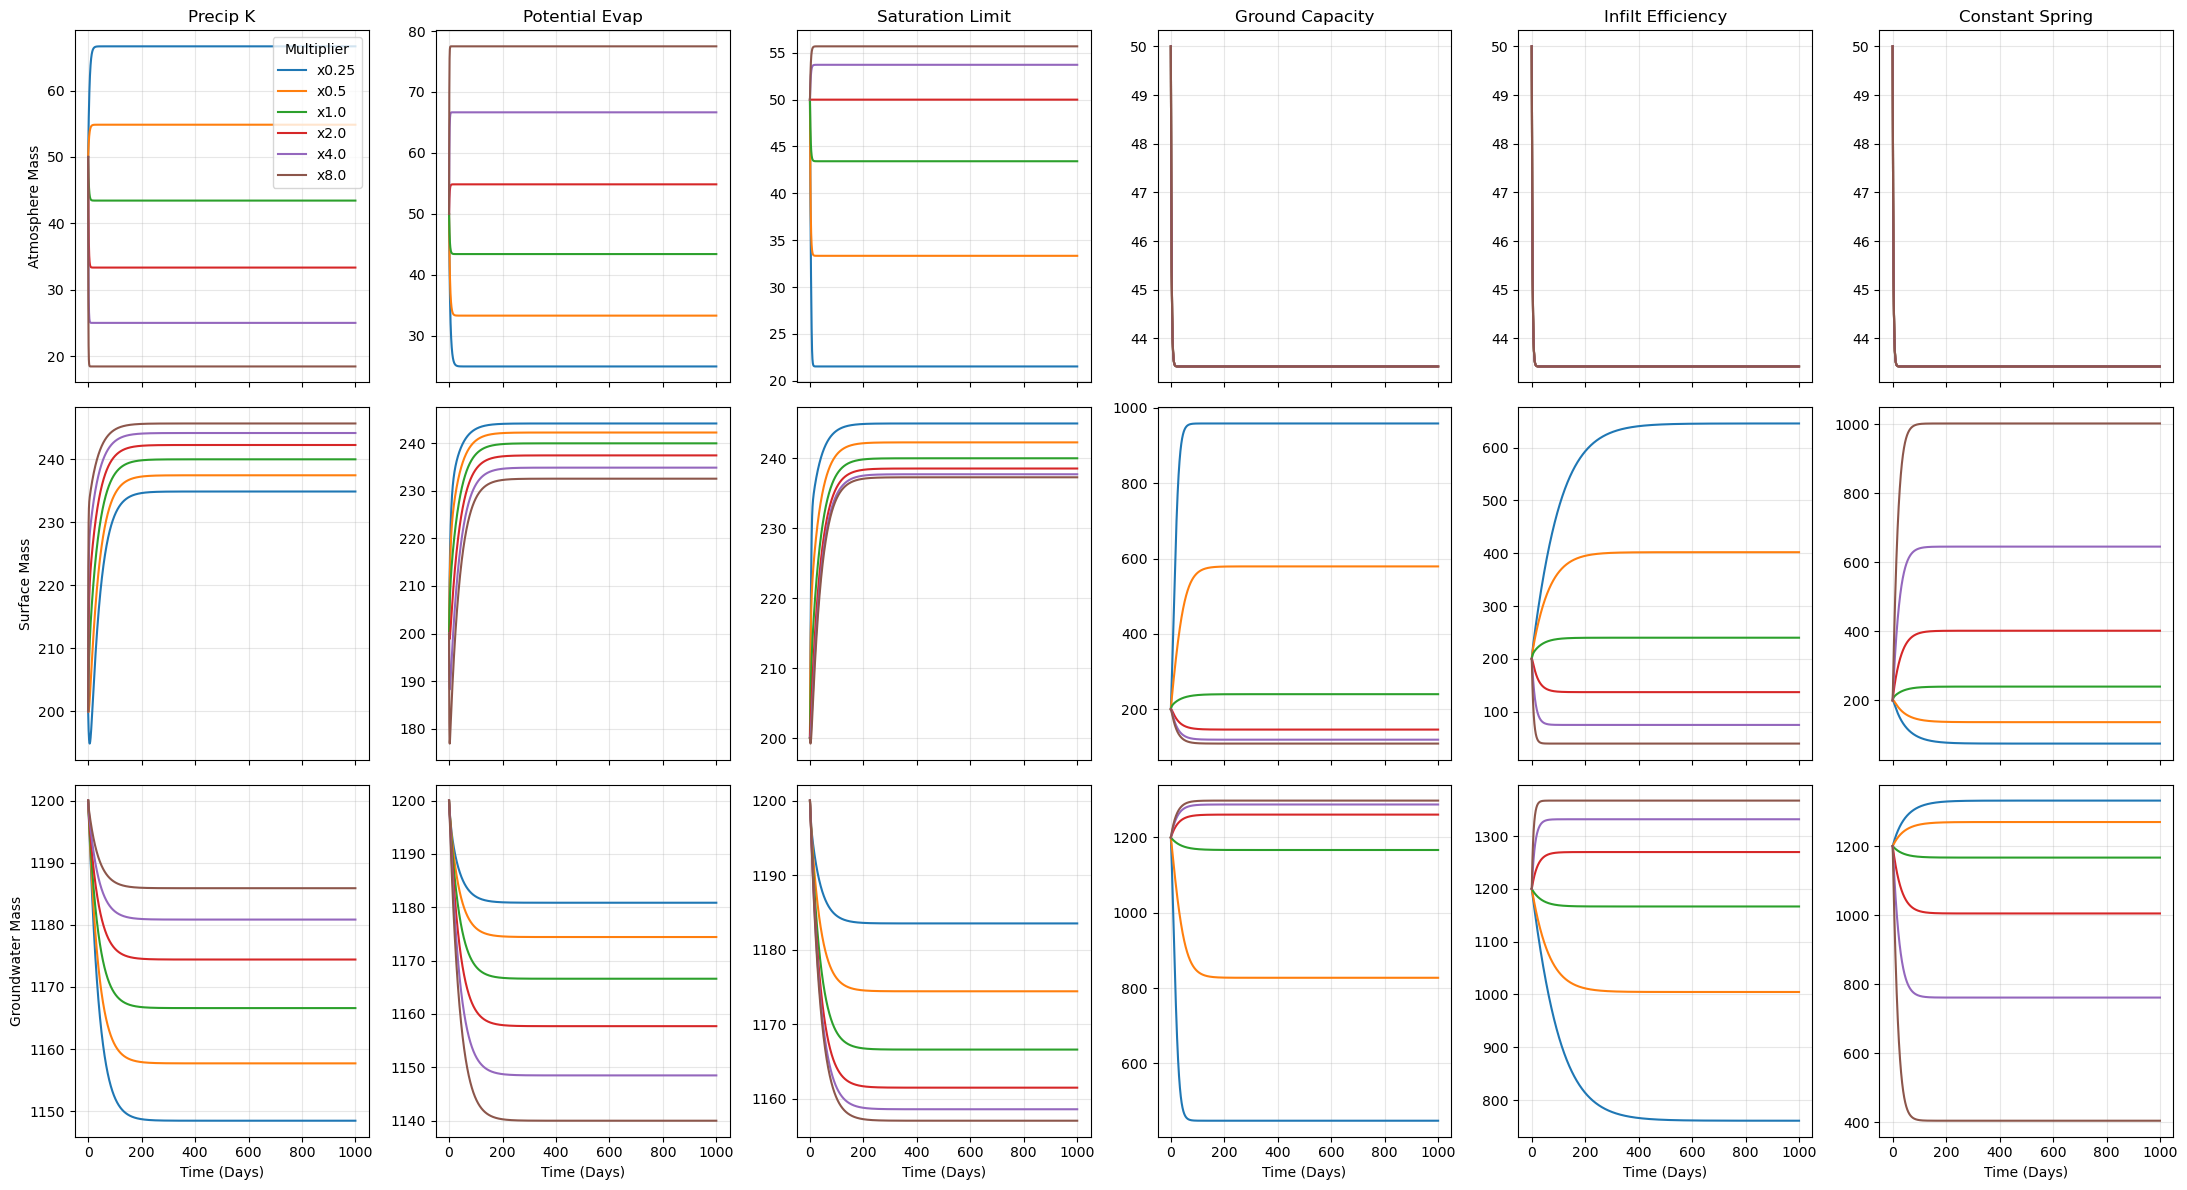

In [20]:
parameter_names = [
    'Precip K', 'Potential Evap', 'Saturation Limit', 
    'Ground Capacity', 'Infilt Efficiency', 'Constant Spring'
]
multipliers = [0.25, 0.5, 1.0, 2.0, 4.0, 8.0]

fig, axes = plt.subplots(3, 6, figsize=(22, 12), sharex=True)

for col, param_name in enumerate(parameter_names):
    for mult in multipliers:

        p_k = K_PRECIP_NONLIN
        e_pot = POTENTIAL_EVAP
        e_sat = SATURATION_LIMIT
        i_cap = GROUND_CAPACITY
        i_eff = INFILT_EFFICIENCY
        b_const = CONSTANT_SPRING
        
        if param_name == 'Precip K':
            p_k *= mult
        elif param_name == 'Potential Evap':
            e_pot *= mult
        elif param_name == 'Saturation Limit':
            e_sat *= mult
        elif param_name == 'Ground Capacity':
            i_cap *= mult
        elif param_name == 'Infilt Efficiency':
            i_eff *= mult
        elif param_name == 'Constant Spring':
            b_const *= mult
            
        p_rule = lambda wa, ws, wg, k=p_k: k * (wa**2)
        e_rule = lambda wa, ws, wg, p=e_pot, s=e_sat: p * max(0, (1 - wa / s))
        i_rule = lambda wa, ws, wg, eff=i_eff, cap=i_cap: eff * ws * (1 - wg / cap)
        b_rule = lambda wa, ws, wg, c=b_const: c
            
        t_s, atm_s, sur_s, grn_s = run_hydrology_engine(
            TOTAL_DAYS, DT, INIT_W_ATM, INIT_W_SUR, INIT_W_GRN,
            p_rule, e_rule, i_rule, b_rule
        )
        
        axes[0, col].plot(t_s, atm_s, label=f'x{mult}')
        axes[1, col].plot(t_s, sur_s)
        axes[2, col].plot(t_s, grn_s)
        
    axes[0, col].set_title(param_name)

for ax in axes.flatten():
    ax.grid(True, alpha=0.3)

axes[0, 0].set_ylabel('Atmosphere Mass')
axes[1, 0].set_ylabel('Surface Mass')
axes[2, 0].set_ylabel('Groundwater Mass')

for col in range(6):
    axes[2, col].set_xlabel('Time (Days)')

axes[0, 0].legend(title="Multiplier")

plt.tight_layout()
plt.show()

### Final Discussion for Students
1. **Conservation Check:** Sum the values in the Sensitivity plot at $t=1000$ for any given color. Does the total water mass remain constant across different precipitation rates?
2. **Time Scales:** Which stock reaches its new equilibrium the fastest? Which is the slowest? Link this to the **spatial and temporal scales** discussed in Lecture 13.
3. **Coupling:** Why does changing the *Atmospheric* rain rate significantly alter the steady-state of the *Groundwater* stock, even though the baseflow rule was not changed?

In [6]:
final_atm = atm_s[-1]
final_sur = sur_s[-1]
final_grn = grn_s[-1]

total_mass = final_atm + final_sur + final_grn

print(f"Atmosphere at t=1000: {final_atm:.2f}")
print(f"Surface at t=1000: {final_sur:.2f}")
print(f"Ground at t=1000: {final_grn:.2f}")
print(f"Total Sum: {total_mass:.2f}")
print(f"Initial Total Sum: {INIT_W_ATM + INIT_W_GRN + INIT_W_SUR}")

Atmosphere at t=1000: 2.63
Surface at t=1000: 131.58
Ground at t=1000: 1315.79
Total Sum: 1450.00
Initial Total Sum: 1450.0


In [7]:
def time_scale(time, data, threshold=0.95):
    initial_val = data[0]
    final_val = data[-1]
    total_change = abs(final_val - initial_val)
    
    current_change = np.abs(data - initial_val)
    
    percent_complete = current_change / total_change
    indices = np.where(percent_complete >= threshold)[0]
    
    if len(indices) > 0:
        return time[indices[0]]
    else:
        return time[-1] 

t_atm = time_scale(t, atm_a)
t_sur = time_scale(t, sur_a)
t_grn = time_scale(t, grn_a)

print(f"Atmosphere: {t_atm:.1f}")
print(f"Surface: {t_sur:.1f}")
print(f"Groundwater: {t_grn:.1f}")

Atmosphere: 50.2
Surface: 71.6
Groundwater: 66.2
